# Homogén adatok átalakítása modell tanításhoz

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_data(fn): 
    with open(fn, 'rt') as f:
        types = next(f).rstrip().split(',')[1:]
        columns = next(f).rstrip().split(',')[1:]
        df = pd.read_csv(f, dtype=dict(zip(columns, types)), index_col=0, names=columns)
        return df

In [3]:
!free -m

'free' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import random
import calendar
from datetime import datetime
'''
def pick_random_days(year):
    random_days = {}
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        random_days[calendar.month_name[month]] = random.sample(range(1, days_in_month + 1), 3)
        date = datetime(year, month, day)
    return random_days

year = 2024
random_days = pick_random_days(year)
random.seed(42)
for month, days in random_days.items():
    
    print(f"{month}: {days}")
    
''' 
import random
from datetime import datetime, timedelta
random.seed(42)
def random_dates(years,validation_day_no, size_reducing_day_no):
    all_random_dates=validation_day_no+size_reducing_day_no
    dates = []
    size_reducing_dates=[]
    for year in years:
        for month in range(1, 13):
            for i in range(all_random_dates):
                # Generate a random day in the current month
                day = random.randint(1, 28)  # To avoid issues with different month lengths
                date = datetime(year, month, day).date()
                if i>=validation_day_no:
                    size_reducing_dates.append(date)
                else:
                    dates.append(date)
    return dates,size_reducing_dates

# Example usage
years = [2022,2023]
random_days,days_to_keep = random_dates(years,3,10)
for date in random_days:
    print(date)

2022-01-21
2022-01-04
2022-01-01
2022-02-03
2022-02-19
2022-02-14
2022-03-23
2022-03-21
2022-03-23
2022-04-26
2022-04-06
2022-04-23
2022-05-04
2022-05-12
2022-05-28
2022-06-03
2022-06-18
2022-06-10
2022-07-22
2022-07-08
2022-07-25
2022-08-27
2022-08-12
2022-08-06
2022-09-21
2022-09-06
2022-09-18
2022-10-22
2022-10-11
2022-10-27
2022-11-03
2022-11-07
2022-11-19
2022-12-05
2022-12-08
2022-12-24
2023-01-05
2023-01-17
2023-01-16
2023-02-14
2023-02-20
2023-02-03
2023-03-24
2023-03-04
2023-03-22
2023-04-15
2023-04-01
2023-04-24
2023-05-27
2023-05-21
2023-05-17
2023-06-20
2023-06-11
2023-06-16
2023-07-03
2023-07-03
2023-07-24
2023-08-18
2023-08-06
2023-08-09
2023-09-23
2023-09-10
2023-09-13
2023-10-11
2023-10-01
2023-10-19
2023-11-03
2023-11-02
2023-11-28
2023-12-24
2023-12-19
2023-12-19


In [5]:
'''import random
random.seed(45)   
print(random.random())
print(random.random())
random.seed(45)   
print(random.random())
print(random.random())
'''

'import random\nrandom.seed(45)   \nprint(random.random())\nprint(random.random())\nrandom.seed(45)   \nprint(random.random())\nprint(random.random())\n'

In [6]:
#data_root = "data/"
from config import data_root
#datafn= "data.csv"

In [7]:
import numpy as np
#raw_data =load_data(data_root+datafn)
raw_data=pd.read_pickle(data_root+'data.pkl')
raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_data.dropna( inplace=True)


In [8]:
raw_data['KOZLEKEDESI_NAP']=pd.to_datetime(raw_data['ELOZO_ESEMENY_IDO']).dt.date
df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
df_to_validate_orig.to_pickle(data_root+'validation_orig.pkl')
del df_to_validate_orig



In [9]:
raw_data.dtypes

VONAL                                       object
VONATSZAM                                    int64
VONTATO_TIPUS                                int64
ELOZO_ESEMENY_IDO                           object
MENETREND_IDO                               object
OSSZ_KESES                                  object
ELOZO_KESES                                 object
KESES                                       object
RELATIV_KESES                              float64
TERV_IDOTARTAM (m)                         float64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
LINE                                         int64
ID                                          object
Kizárásszám                                 object
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza              

In [10]:
import datetime
def convert_time_to_minute(input):
    if isinstance(input,datetime.time):
        return float(input.hour*60+input.minute)
    #TODO does totalseconds return some decent value for negativ timedelta? 
    # ANS: it is good
    if isinstance(input,datetime.timedelta):
        ret = input.total_seconds()/60
       # if datetime.timedelta(0)>input:
       #     return -ret
        return ret
    if isinstance(input,float):
        return input
    return -1.0

In [11]:
# átalakítjuk időt percekké

In [12]:
def prepare_for_training(raw_data):
    raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']] = raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']].map(convert_time_to_minute)
    
    
    raw_data['VONAL STATUSZ VALTOZOTT']=raw_data['VONAL STATUSZ VALTOZOTT'].head().astype(float)
    raw_data.fillna(0.0,inplace=True)
    
prepare_for_training(raw_data)

In [13]:
#TODO boolean vs categorical?
#TODO Vonal, Line mit kellene kezdeni velük? kicsit kölséges használni őket..
#raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']]=raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']].astype("category")

# sklearn nem bír  category-kal
#raw_data.drop(columns=['VONATSZAM','VONAL','VONTATO_TIPUS'],inplace=True)

# vonatszám kell majd spearman-hez
raw_data.drop(columns=['VONAL','VONTATO_TIPUS'],inplace=True)


In [14]:

#
raw_data=raw_data.drop(columns=['ELOZO_ESEMENY_IDO','ID','Kizárásszám','Kezdés','Befejezés','LINE','OSSZ_KESES'])


In [15]:
raw_data.dtypes


VONATSZAM                                    int64
MENETREND_IDO                              float64
ELOZO_KESES                                float64
KESES                                      float64
RELATIV_KESES                              float64
TERV_IDOTARTAM (m)                         float64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza                          float64
Lassúmenet mértéke (km/h)                  float64
Lassúmenet mértéke motorvonatra (km/h)     float64
Fels.vez. kikapcsolása                     float64
I                                          float64
E                                          float64
ÁI                                         float64
ÁE                             

In [16]:
raw_data.head()

,VONATSZAM,MENETREND_IDO,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,t,tn,r,...,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
47,2019,241.0,1.166667,-0.216667,-0.216667,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.550000,-0.550000,0.0,2022-01-01
50,2019,245.0,1.716667,0.133333,0.133333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,2022-01-01
52,2019,250.0,1.800000,-0.433333,-0.433333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.600000,-0.600000,0.0,2022-01-01
56,2019,256.0,2.366667,-0.383333,-0.383333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.583333,-0.583333,0.0,2022-01-01
60,2019,261.0,2.300000,0.416667,0.416667,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.350000,-0.350000,0.0,2022-01-01


In [17]:
df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
#NEM HASZNÁLJUK AZ EGÉSZ ADATOT
df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]

In [18]:
#ez is kell spearmann-hez
#df_to_validate.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)
#df_remaining.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)


In [19]:
#raw_data.to_csv(data_root+'preprocessed_data.csv', index=False)
df_to_validate.to_csv(data_root+'validation_data.csv', index=False)
df_remaining.to_csv(data_root+'train_test_data.csv', index=False)



In [20]:
del raw_data
del df_to_validate
del df_remaining

# Modellek tanítása

A modellek tanításához elég innentől futtatni.

In [1]:
import pandas as pd
data_root = "data/"

raw_data=pd.read_csv(data_root+'train_test_data.csv')
#raw_data['VONAL STATUSZ VALTOZOTT']=raw_data['VONAL STATUSZ VALTOZOTT'].head().astype(float)



In [181]:

raw_data.head()


,VONATSZAM,MENETREND_IDO,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,t,tn,r,...,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
0,2181,3.0,0.116667,0.166667,0.083333,2.0,14.3,10.1,4.8,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.233333,0.116667,0.0,2022-01-04
1,2181,7.0,0.766667,-1.116667,-0.279167,4.0,14.3,10.1,4.8,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.016667,-0.254167,0.0,2022-01-04
2,2181,10.0,-0.350000,-0.916667,-0.305556,3.0,14.3,10.1,4.8,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.850000,-0.283333,0.0,2022-01-04
3,2181,11.0,-1.266667,-0.366667,-0.366667,1.0,14.3,10.1,4.8,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,0.0,2022-01-04
4,2181,13.0,0.166667,0.100000,0.050000,2.0,14.3,10.1,4.8,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.050000,0.0,2022-01-04


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def split_train_test(data, normalize=False):
    raw_data=data.copy()
    X_scaler=None
    y_scaler=None
    pd_y= raw_data[['KESES']]
    pd_X = raw_data.drop(columns=['KESES'])
    if 'RELATIV_KESES' in raw_data.columns:
        pd_X.drop(columns=['RELATIV_KESES'],inplace=True)
    if normalize:
        X_scaler = MinMaxScaler()
        pd_X[pd_X.columns] = X_scaler.fit_transform(pd_X[pd_X.columns])
        y_scaler=MinMaxScaler()
        pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])
   
    '''
    if normalize:
        scaler = MinMaxScaler()
        pd_X[pd_X.columns] = scaler.fit_transform(pd_X[pd_X.columns])
    '''
    X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.3, random_state=44)
    return X_train, X_test, y_train, y_test,X_scaler,y_scaler

In [3]:
X_train, X_test, y_train, y_test,_,_ = split_train_test(raw_data)
X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)

''''
TrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]
X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
TeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]
X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
'''

"'\nTrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\nTeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\n"

In [4]:
X_train.head()

,MENETREND_IDO,ELOZO_KESES,TERV_IDOTARTAM (m),tx,t,tn,r,Érintett objektum típusa,Lassúmenet típusa,Lassúmenet hossza,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT
447118,11.0,-1.316667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.183333,-0.183333,0.0
1024071,422.0,0.700000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.016667,-0.008333,0.0
48134,588.0,0.216667,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.216667,-0.054167,0.0
732685,1196.0,2.000000,0.0,10.4,8.2,5.9,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
124196,507.0,4.700000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.633333,-0.316667,0.0


# DecisionTreeRegressor

In [5]:
max_depth=[]

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/
def train_DRT(X_train, X_test, y_train):
    
    # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None]
    }
    dtree_reg = DecisionTreeRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    predictions = model.predict(X_test)
    return model, predictions
'''
def train_DRTF(X_train, X_test, y_train):
    
        # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dtree_reg = RandomForestRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    predictions = model.predict(X_test)
    return model, predictions
'''
model, predictions = train_DRT(X_train,X_test, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [120]:
'''
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8), dpi=150)
plot_tree(model, feature_names=pd_X.columns);
'''

'\nfrom sklearn.tree import plot_tree\nimport matplotlib.pyplot as plt\nplt.figure(figsize=(10,8), dpi=150)\nplot_tree(model, feature_names=pd_X.columns);\n'

In [6]:

def evaluate_model(X_test, y_test, predictions):
    eval_df=pd.concat([X_test[['TERV_IDOTARTAM (m)']],y_test],axis=1)
    eval_df['predictions']=predictions
    eval_df['Tény']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES']
    eval_df['Pred']=eval_df['TERV_IDOTARTAM (m)']+eval_df['predictions']
    eval_df=eval_df[eval_df['TERV_IDOTARTAM (m)']>0]
    eval_df['PE']=(eval_df['Tény']-eval_df['Pred'])/eval_df['Tény'] *100
    eval_df['MAPE']=abs((eval_df['Tény']-eval_df['Pred'])/eval_df['Tény']) *100
    eval_df['PE1']=(eval_df['KESES']-eval_df['predictions'])/eval_df['KESES'] *100
    eval_df['MAPE1']=abs((eval_df['KESES']-eval_df['predictions'])/eval_df['KESES']) *100

    return eval_df

In [7]:
eval_df = evaluate_model(X_test, y_test, predictions)


In [8]:
eval_df.head()

,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
1096781,1.0,-0.283333,-0.219197,0.716667,0.780803,-8.949322,8.949322,22.636520,22.636520
1016002,1.0,0.283333,0.135181,1.283333,1.135181,11.544309,11.544309,52.288930,52.288930
53208,2.0,-0.066667,0.699738,1.933333,2.699738,-39.641597,39.641597,1149.606299,1149.606299
1032627,1.0,-0.200000,-0.195810,0.800000,0.804190,-0.523744,0.523744,2.094976,2.094976
830943,3.0,0.000000,0.047569,3.000000,3.047569,-1.585626,1.585626,-inf,inf


In [9]:
eval_df[eval_df['MAPE1']>100]

,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
53208,2.0,-0.066667,0.699738,1.933333,2.699738,-39.641597,39.641597,1149.606299,1149.606299
830943,3.0,0.000000,0.047569,3.000000,3.047569,-1.585626,1.585626,-inf,inf
189855,1.0,-0.350000,0.283829,0.650000,1.283829,-97.512133,97.512133,181.093962,181.093962
651312,1.0,-0.566667,0.157391,0.433333,1.157391,-167.090150,167.090150,127.774820,127.774820
553411,4.0,-0.416667,0.312240,3.583333,4.312240,-20.341594,20.341594,174.937705,174.937705
...,...,...,...,...,...,...,...,...,...
69106,3.0,0.450000,-0.026293,3.450000,2.973707,13.805597,13.805597,105.842907,105.842907
158066,2.0,-0.183333,-0.564781,1.816667,1.435219,20.997136,20.997136,-208.062526,208.062526
608201,4.0,0.000000,0.699738,4.000000,4.699738,-17.493438,17.493438,-inf,inf
1130930,1.0,0.000000,0.047569,1.000000,1.047569,-4.756878,4.756878,-inf,inf


In [10]:
eval_df[eval_df['MAPE']>100].head()


,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
651312,1.0,-0.566667,0.157391,0.433333,1.157391,-167.090150,167.090150,127.774820,127.774820
1147611,2.0,-1.400000,-0.026293,0.600000,1.973707,-228.951153,228.951153,98.121923,98.121923
99653,1.0,-0.533333,0.131364,0.466667,1.131364,-142.435159,142.435159,124.630764,124.630764
408371,1.0,-0.533333,0.135181,0.466667,1.135181,-143.253150,143.253150,125.346506,125.346506
1117387,1.0,-0.500000,0.135181,0.500000,1.135181,-127.036273,127.036273,127.036273,127.036273


In [11]:
eval_df['PE'].describe()

count    3.347440e+05
mean             -inf
std               NaN
min              -inf
25%     -1.289340e+01
50%     -2.315416e+00
75%      4.498052e+00
max      1.629843e+04
Name: PE, dtype: float64

In [12]:
eval_df['PE1'].describe()

C:\Users\ELTE\miniconda3\envs\gtfs_env_311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    3.347420e+05
mean              NaN
std               NaN
min              -inf
25%     -6.544933e+00
50%      2.773835e+01
75%      7.796329e+01
max               inf
Name: PE1, dtype: float64

In [12]:
import joblib
# modellek mentése, beolvasása:
# könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

import matplotlib.pyplot as plt

import os
model_location="model/"
# Check if the directory exists
if not os.path.exists(model_location):
    # Create the directory
    os.makedirs(model_location)

def get_location_and_name(model_name, model_desc,data_desc):
    loc=   model_location+'/'+model_name+'/'+data_desc+'/'+model_desc+"/"
    name = model_name + '_' + data_desc + '_' + model_desc
    return loc, name
def save_sklearn_model(model,model_name,data_desc,model_desc='base'):
    loc,name=get_location_and_name(model_name,model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc)
    # Save the model to a file
    joblib.dump(model, f'{loc}{name}.joblib')
    
def get_nn_model_name(epochs, data_desc):
    return f'NN_{data_desc}_epoch_{epochs}'

def save_NN(model,X_scaler,y_scaler,history,data_desc, model_desc='base'):
    loc,name=get_location_and_name('NN',model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc) 
    save_sklearn_model(X_scaler,'X_scaler',data_desc)
    save_sklearn_model(y_scaler,'y_scaler',data_desc)
    torch.save(model, loc+name+'.pth')


    for k, v in history.items():
        plt.plot(v, label='lr=' + str(k))

    plt.legend(loc="upper left")

    plt.savefig(loc+'history.png')

def load_NN(path):
    ret={}
    for f in os.listdir(path):
        if f.endswith('.pth'):
            print('Loading model:', path+f)
            ret['model'] = torch.load(path+f, weights_only=False)
        elif f.endswith('.joblib'):
            if 'X_scaler' in f:
                ret['X_scaler'] = joblib.load(path+f)
            elif 'y_scaler' in f:
                ret['y_scaler'] = joblib.load(path+f)
            else:
                print(f'Unspecified joblib file: {f}')
        else:
                print(f'Unspecified file: {f}')
    return ret

def load_NNs(model_path):
    # könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

    ret={}
    #dir=data_desc
    for dir in os.listdir(model_path+'NN'):
        ret[dir]={}
        if os.path.isdir(model_path+'NN/'+dir+'/'):
            print('reading '+ dir)
            #dir2=model_desc
            for dir2 in os.listdir(dir):
                print('reading '+ dir+'/'+dir2)
                ret[dir][dir2]['model']=load_NN(model_path+'NN/'+dir+'/'+dir2)
                ret[dir][dir2]['data_desc']=dir
                ret[dir][dir2]['model_desc']=dir2
    return ret

def load_NN_by_desc(model_desc,data_desc):
    loc,name= get_location_and_name('NN',model_desc,data_desc)
    ret=load_NN(loc)
    ret['model_desc']=model_desc
    ret['data_desc']=data_desc
    return ret

def load_sk_by_desc(model_name,model_desc,data_desc):
    loc,name= get_location_and_name(model_name,model_desc,data_desc)
    return {'model':joblib.load(f'{loc}/{name}.joblib'),'model_name':model_name,'data_desc':data_desc,'model_desc':model_desc}
    
    
#def load_models():
    
    



In [14]:
save_sklearn_model(model,'RT','Base')


In [15]:
del model

# Egyszerű neurális háló

In [131]:
X_train.dtypes


MENETREND_IDO                              float64
ELOZO_KESES                                float64
RELATIV_KESES                              float64
TERV_IDOTARTAM (m)                         float64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza                          float64
Lassúmenet mértéke (km/h)                  float64
Lassúmenet mértéke motorvonatra (km/h)     float64
Fels.vez. kikapcsolása                     float64
I                                          float64
E                                          float64
ÁI                                         float64
ÁE                                         float64
Kizárás (1=VZ,2=LJ)                        float64
Kiutalt menetvonalak zavartatás

plusz normalizálás kellhet:
normalized_df=(df-df.mean())/df.std()
to use min-max normalization:

normalized_df=(df-df.min())/(df.max()-df.min())

kicsit alaposabb tréneléshez: 

https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/

In [16]:
print('hello')

hello


In [17]:
#X=pd_X.values
#y=pd_y.values
import torch
# train-test split of the dataset
raw_data.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'],inplace=True)

X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(raw_data,True)
def get_data_tensors(X_train, X_test, y_train, y_test):
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    return X_train_t, X_test_t, y_train_t, y_test_t
X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)


C:\Users\ELTE\AppData\Local\Temp\ipykernel_18172\3857565312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


In [18]:
input_size=X_train.shape[1]

In [19]:
import torch
import torch.nn as nn
# Define the model
        


def get_NN_model(input_size):
    model = nn.Sequential(
        nn.Linear(input_size, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )
    return model

In [136]:
model_nn = get_NN_model(input_size)

In [20]:
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
def get_optimizer(model, lr=0.0001):
    loss_fn = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr)
    return optimizer, loss_fn

In [138]:
optimizer, loss_fn = get_optimizer(model_nn, 0.0001)

In [139]:
X_train.shape

(815943, 24)

In [21]:
import numpy as np
import torch
import tqdm
import copy
from sklearn.model_selection import train_test_split

'''
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
'''
def reset_model(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()

def train_NN(X_train, X_test, y_train, y_test, model, loss_fn, optimizer,n_epochs = 2):
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = {}
    for lr in [0.0001, 0.001, 0.0005]:
        reset_model(model)
        optimizer, loss_fn=get_optimizer(model, lr)
        history[lr] = []
        # training loop
        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred = model(X_batch)
                    loss = loss_fn(y_pred, y_batch)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    bar.set_postfix(mse=float(loss))
            # evaluate accuracy at end of each epoch
            model.eval()
            y_pred = model(X_test)
            mse = loss_fn(y_pred, y_test)
            mse = float(mse)
            print("Epoch:",epoch,'MSE:', mse, 'Best mse',best_mse)
            history[lr].append(mse)
            if mse < best_mse:
                best_mse = mse
                best_weights = copy.deepcopy(model.state_dict())
     
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return history, best_mse, best_weights, model

In [ ]:
history, best_mse, best_weights, model_nn=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model_nn, loss_fn, optimizer,20)

Epoch: 0 MSE: 5.040772066422505e-06 Best mse inf
Epoch: 1 MSE: 3.1390407002618304e-06 Best mse 5.040772066422505e-06
Epoch: 2 MSE: 2.256999550809269e-06 Best mse 3.1390407002618304e-06
Epoch: 3 MSE: 1.5119883300940273e-06 Best mse 2.256999550809269e-06
Epoch: 4 MSE: 1.2034764722557156e-06 Best mse 1.5119883300940273e-06
Epoch: 5 MSE: 1.0828345011759666e-06 Best mse 1.2034764722557156e-06
Epoch: 6 MSE: 1.006958655125345e-06 Best mse 1.0828345011759666e-06
Epoch: 7 MSE: 9.562402283336269e-07 Best mse 1.006958655125345e-06
Epoch: 8 MSE: 9.060535717253515e-07 Best mse 9.562402283336269e-07
Epoch: 9 MSE: 8.612513511252473e-07 Best mse 9.060535717253515e-07
Epoch: 10 MSE: 8.137428721965989e-07 Best mse 8.612513511252473e-07
Epoch: 11 MSE: 7.804831057001138e-07 Best mse 8.137428721965989e-07
Epoch: 12 MSE: 7.55545215724851e-07 Best mse 7.804831057001138e-07
Epoch: 3 MSE: 7.801287438269355e-07 Best mse 5.735263925998879e-07
Epoch: 4 MSE: 4.0129569356395223e-07 Best mse 5.735263925998879e-07
Ep

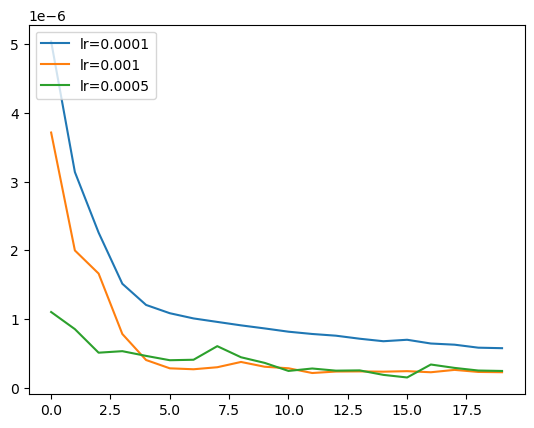

In [152]:
import matplotlib.pyplot as plt

for k, v in history.items():
    plt.plot(v, label = 'lr='+str(k))
    
plt.legend(loc="upper left")




In [ ]:
y_pred = model_nn(X_test_t)

In [ ]:
y_pred=y_pred.detach().numpy()

In [ ]:
#TODO kell ez? 

X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)

In [ ]:
y_pred=y_scaler.inverse_transform(y_pred)


In [ ]:
eval_df_nn=evaluate_model(X_test, y_test, y_pred)

In [ ]:
eval_df_nn.head()

,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
1096781,1.0,-2.833336e-01,-0.301531,0.716666,0.698469,2.539148,2.539148,-6.422540e+00,6.422540e+00
1016002,1.0,2.833343e-01,0.271183,1.283334,1.271183,0.946886,0.946886,4.288826e+00,4.288826e+00
53208,2.0,-6.666564e-02,-0.066931,1.933334,1.933069,0.013742,0.013742,-3.985105e-01,3.985105e-01
1032627,1.0,-1.999996e-01,-0.216998,0.800000,0.783002,2.124822,2.124822,-8.499306e+00,8.499306e+00
830943,3.0,3.164013e-07,0.014936,3.000000,3.014936,-0.497866,0.497866,-4.720583e+06,4.720583e+06


In [ ]:
eval_df_nn['MAPE'].describe()

count    3.347450e+05
mean     6.562679e+02
std      1.044971e+05
min      1.776357e-13
25%      4.005444e-01
50%      7.820961e-01
75%      2.006230e+00
max      2.070871e+07
Name: MAPE, dtype: float64

In [ ]:
eval_df_nn['MAPE1'].describe()


count    3.347450e+05
mean     2.608368e+05
std      2.385684e+06
min      6.622777e-07
25%      2.135588e+00
50%      4.289823e+00
75%      8.595523e+00
max      5.857634e+08
Name: MAPE1, dtype: float64

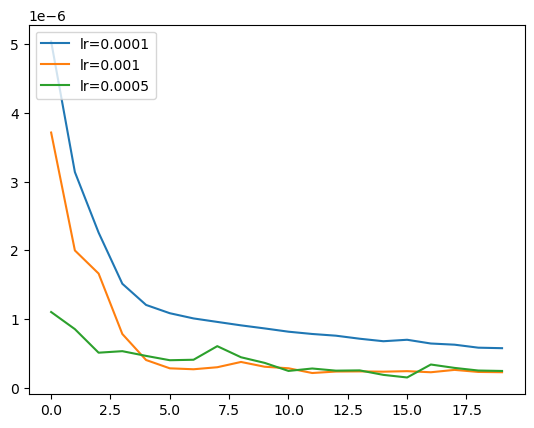

In [ ]:
save_NN(model_nn,X_scaler,y_scaler,history,'Base')

In [ ]:
del model_nn

# Kisebb adaton:

most rendelkezésre álló adat:
- utastájékoztatásból terv- és tényídők
- időjárás

Azaz dobjuk a lassújel és vágányzár adatokat


In [ ]:
raw_data.columns

Index(['MENETREND_IDO', 'ELOZO_KESES', 'KESES', 'RELATIV_KESES',
       'TERV_IDOTARTAM (m)', 'tx', 't', 'tn', 'r', 'Érintett objektum típusa',
       'Lassúmenet típusa', 'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása', 'I',
       'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO VONAT KESES', 'ELOZO VONAT RELATIV KESES',
       'VONAL STATUSZ VALTOZOTT'],
      dtype='object')

In [9]:
attrs_to_use=['MENETREND_IDO','ELOZO_KESES','KESES','tx','t','tn','r','TERV_IDOTARTAM (m)','ELOZO VONAT KESES','ELOZO VONAT RELATIV KESES']

In [23]:
raw_data_small=raw_data[attrs_to_use]


In [24]:
def train_and_evaluate_DRT(data):
    history=None
    X_scaler=None
    y_scaler=None
    X_train, X_test, y_train, y_test,_,_ = split_train_test(data)
    model, predictions = train_DRT(X_train,X_test, y_train)
    eval_df = evaluate_model(X_test, y_test, predictions)
    return model,eval_df,X_scaler,y_scaler,history





In [25]:
raw_data_small.head()

,MENETREND_IDO,ELOZO_KESES,KESES,tx,t,tn,r,TERV_IDOTARTAM (m),ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES
0,3.0,0.116667,0.166667,14.3,10.1,4.8,0.4,2.0,0.233333,0.116667
1,7.0,0.766667,-1.116667,14.3,10.1,4.8,0.4,4.0,-1.016667,-0.254167
2,10.0,-0.350000,-0.916667,14.3,10.1,4.8,0.4,3.0,-0.850000,-0.283333
3,11.0,-1.266667,-0.366667,14.3,10.1,4.8,0.4,1.0,-0.333333,-0.333333
4,13.0,0.166667,0.100000,14.3,10.1,4.8,0.4,2.0,0.100000,0.050000


In [26]:
model_s,eval_df_s,_,_,_=train_and_evaluate_DRT(raw_data_small)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [27]:
eval_df_s.head()

,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
1096781,1.0,-0.283333,-0.219197,0.716667,0.780803,-8.949322,8.949322,22.636520,22.636520
1016002,1.0,0.283333,0.135181,1.283333,1.135181,11.544309,11.544309,52.288930,52.288930
53208,2.0,-0.066667,0.699738,1.933333,2.699738,-39.641597,39.641597,1149.606299,1149.606299
1032627,1.0,-0.200000,-0.195810,0.800000,0.804190,-0.523744,0.523744,2.094976,2.094976
830943,3.0,0.000000,0.047569,3.000000,3.047569,-1.585626,1.585626,-inf,inf


In [28]:
eval_df_s[['MAPE','MAPE1']].describe()


,MAPE,MAPE1
count,3.347440e+05,3.347420e+05
mean,inf,inf
std,NaN,NaN
min,0.000000e+00,0.000000e+00
25%,3.141642e+00,2.023356e+01
50%,8.075548e+00,5.158378e+01
75%,2.080130e+01,1.132314e+02
max,inf,inf


In [29]:
save_sklearn_model(model_s,'RT','Small')


In [30]:
del model_s

In [33]:
raw_data_small=raw_data[attrs_to_use]
def train_and_evaluate_NN(data, epoch=20, lr=0.0001):
    X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(data,True)
    X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)
    input_size=X_train.shape[1]
    model = get_NN_model(input_size)
    #optimizer, loss_fn = get_optimizer(model, lr)
    history, best_mse, best_weights, model=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model, None, None, epoch)
    y_pred = model(X_test_t)
    y_pred=y_pred.detach().numpy()
    X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
    y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)
    y_pred=y_scaler.inverse_transform(y_pred)
    eval_df_nn = evaluate_model(X_test, y_test, y_pred)
    return model,eval_df_nn,X_scaler,y_scaler,history


In [34]:
model_nn_s,eval_df_nn_s,X_scaler_s,y_scaler, history_s=train_and_evaluate_NN(raw_data_small,20)


    

C:\Users\ELTE\AppData\Local\Temp\ipykernel_18172\3857565312.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


Epoch: 0 MSE: 3.41435479640495e-05 Best mse inf
Epoch: 1 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 2 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 3 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 4 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 5 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 6 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 7 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 8 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 9 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 10 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 11 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 12 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 13 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 14 MSE: 3.41435479640495e-05 Best mse 3.41435479640495e-05
Epoch: 15 MSE: 3.41435479640495e-05 B

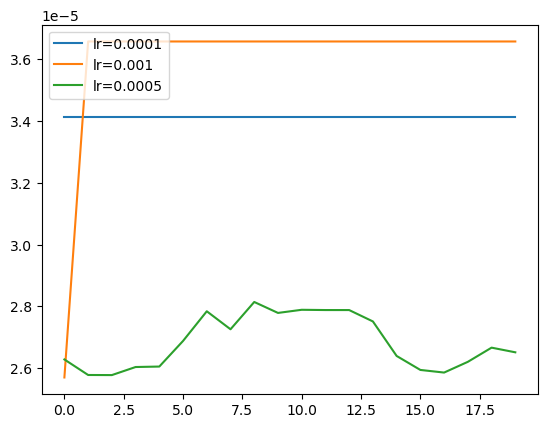

In [35]:
save_NN(model_nn_s,X_scaler_s,y_scaler,history_s,'Small')



In [36]:
eval_df_nn_s.head()

,TERV_IDOTARTAM (m),KESES,predictions,Tény,Pred,PE,MAPE,PE1,MAPE1
1096781,1.0,-2.833336e-01,-0.093632,0.716666,0.906368,-26.470010,26.470010,6.695345e+01,6.695345e+01
1016002,1.0,2.833343e-01,0.158543,1.283334,1.158544,9.723950,9.723950,4.404366e+01,4.404366e+01
53208,2.0,-6.666564e-02,0.946883,1.933334,2.946883,-52.424911,52.424911,1.520347e+03,1.520347e+03
1032627,1.0,-1.999996e-01,0.007799,0.800000,1.007799,-25.974796,25.974796,1.038994e+02,1.038994e+02
830943,3.0,3.164013e-07,0.248797,3.000000,3.248798,-8.293236,8.293236,-7.863340e+07,7.863340e+07


In [37]:
eval_df_nn_s[['MAPE','MAPE1']].describe()

,MAPE,MAPE1
count,3.347450e+05,3.347450e+05
mean,8.957245e+03,2.942559e+06
std,1.335253e+06,2.160184e+07
min,6.223986e-05,5.493332e-04
25%,6.226832e+00,4.523875e+01
50%,1.494601e+01,7.624991e+01
75%,3.200387e+01,1.394789e+02
max,2.748233e+08,8.690156e+08


In [38]:
del model_nn_s

In [39]:
del raw_data_small
del raw_data
    

# loading the models and validate them

In [23]:
import pandas as pd
from config import data_root

In [24]:
validation_data=pd.read_csv(data_root+'validation_data.csv')
y=validation_data['KESES']
X=validation_data.drop(columns=['KESES','RELATIV_KESES'])
X_additional=X[['VONATSZAM','KOZLEKEDESI_NAP']]
X.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
if 'KESES' in attrs_to_use:
    attrs_to_use.remove('KESES')
X_small=X[attrs_to_use]





In [75]:
#model/data_desc/model_desc
base_RT = load_sk_by_desc('RT','base','Base')['model']
small_RT = load_sk_by_desc('RT','base','Small')['model']


In [76]:
base_RT.feature_names_in_

array(['MENETREND_IDO', 'ELOZO_KESES', 'TERV_IDOTARTAM (m)', 'tx', 't',
       'tn', 'r', 'Érintett objektum típusa', 'Lassúmenet típusa',
       'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása',
       'I', 'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO VONAT KESES', 'ELOZO VONAT RELATIV KESES',
       'VONAL STATUSZ VALTOZOTT'], dtype=object)

In [77]:
small_RT.feature_names_in_


array(['MENETREND_IDO', 'ELOZO_KESES', 'tx', 't', 'tn', 'r',
       'TERV_IDOTARTAM (m)', 'ELOZO VONAT KESES',
       'ELOZO VONAT RELATIV KESES'], dtype=object)

In [26]:
y_pred_dt_base=small_RT.predict(X_small)
#small_RT_res=evaluate_model(X_small,y,y_pred)



In [27]:
y_pred_dt_small=base_RT.predict(X)
#base_RT_res=evaluate_model(X,y,y_pred)

In [28]:
del small_RT
del base_RT

In [29]:
validation_data.head()

,VONATSZAM,MENETREND_IDO,ELOZO_KESES,KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,t,tn,r,...,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP
0,2019,241.0,1.166667,-0.216667,-0.216667,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.550000,-0.550000,0.0,2022-01-01
1,2019,245.0,1.716667,0.133333,0.133333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,0.0,2022-01-01
2,2019,250.0,1.800000,-0.433333,-0.433333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.600000,-0.600000,0.0,2022-01-01
3,2019,256.0,2.366667,-0.383333,-0.383333,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.583333,-0.583333,0.0,2022-01-01
4,2019,261.0,2.300000,0.416667,0.416667,1.0,14.1,12.2,7.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.350000,-0.350000,0.0,2022-01-01


In [30]:
import torch
base_X_scaler=load_sk_by_desc('X_scaler','base','base')['model']
base_y_scaler=load_sk_by_desc('y_scaler','base','base')['model']

X_t = torch.tensor(base_X_scaler.transform(X), dtype=torch.float32)
nn_base=load_NN('./model/NN/base/base/')['model']
y_pred_nn_base=base_y_scaler.inverse_transform(nn_base(X_t).detach().numpy())
del base_X_scaler
del base_y_scaler
del nn_base
del X_t


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- RELATIV_KESES


In [ ]:
attrs_to_use

In [31]:


small_X_scaler=load_sk_by_desc('X_scaler','base','Small')['model']
small_y_scaler=load_sk_by_desc('y_scaler','base','Small')['model']

X_t = torch.tensor(small_X_scaler.transform(X_small), dtype=torch.float32)
nn_small=load_NN('./model/NN/Small/base/')['model']
y_pred_nn_small=small_y_scaler.inverse_transform(nn_small(X_t).detach().numpy())
del small_X_scaler
del small_y_scaler
del nn_small
del X_t



Unspecified file: history.png
Loading model: ./model/NN/Small/base/NN_Small_base.pth


In [32]:
#del y
del X
del X_small

In [33]:
names = ['P-NN-small','P-DT','P-DT-small','KESES']
#preds=[y_pred_nn_base.squeeze(),y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
preds=[y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
cols_to_add=pd.DataFrame(dict(zip(names,preds)))

In [ ]:
type(y_pred_dt_small[:5])

In [ ]:
y_pred_dt_small.reshape(1,).shape

In [ ]:
type(y_pred_nn_base[:5])

In [ ]:
y_pred_nn_base.squeeze().shape

In [34]:
df_to_validate_orig=pd.read_pickle(data_root+'validation_orig.pkl')
df_to_validate_orig.drop(columns=['KESES'], inplace=True)

In [35]:
df_to_validate_orig.reset_index(drop=True, inplace=True)
cols_to_add.reset_index(drop=True, inplace=True)

In [36]:
eval_df=pd.concat([df_to_validate_orig,cols_to_add], axis=1)

In [37]:
eval_df.head()

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP,P-NN-small,P-DT,P-DT-small,KESES
0,2,2019,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-0.216667,1.0,14.1,...,0.0,0.0,-1 days +23:59:27,-0.550000,False,2022-01-01,-0.021600,-0.381898,-0.381898,-0.216667
1,2,2019,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0.133333,1.0,14.1,...,0.0,0.0,0 days 00:00:04,0.066667,False,2022-01-01,-0.000548,-0.194139,-0.194139,0.133333
2,2,2019,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-0.433333,1.0,14.1,...,0.0,0.0,-1 days +23:59:24,-0.600000,False,2022-01-01,-0.027108,-0.372194,-0.372194,-0.433333
3,2,2019,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-0.383333,1.0,14.1,...,0.0,0.0,-1 days +23:59:25,-0.583333,False,2022-01-01,-0.029669,-0.372194,-0.372194,-0.383333
4,2,2019,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0.416667,1.0,14.1,...,0.0,0.0,-1 days +23:59:39,-0.350000,False,2022-01-01,-0.020017,-0.381898,-0.381898,0.416667


In [38]:
eval_df.to_pickle(data_root+'validation_res.pkl')

In [46]:
preds_=pd.read_pickle(data_root+'validation_res.pkl')


In [47]:
preds_

,VONAL,VONATSZAM,VONTATO_TIPUS,ELOZO_ESEMENY_IDO,MENETREND_IDO,OSSZ_KESES,ELOZO_KESES,RELATIV_KESES,TERV_IDOTARTAM (m),tx,...,Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO VONAT KESES,ELOZO VONAT RELATIV KESES,VONAL STATUSZ VALTOZOTT,KOZLEKEDESI_NAP,P-NN-small,P-DT,P-DT-small,KESES
0,2,2019,465,2022-01-01 04:00:00,04:01:00,0 days 00:00:57,0 days 00:01:10,-0.216667,1.0,14.1,...,0.0,0.0,-1 days +23:59:27,-0.550000,False,2022-01-01,-0.021600,-0.381898,-0.381898,-0.216667
1,2,2019,465,2022-01-01 04:04:00,04:05:00,0 days 00:01:51,0 days 00:01:43,0.133333,1.0,14.1,...,0.0,0.0,0 days 00:00:04,0.066667,False,2022-01-01,-0.000548,-0.194139,-0.194139,0.133333
2,2,2019,465,2022-01-01 04:09:00,04:10:00,0 days 00:01:22,0 days 00:01:48,-0.433333,1.0,14.1,...,0.0,0.0,-1 days +23:59:24,-0.600000,False,2022-01-01,-0.027108,-0.372194,-0.372194,-0.433333
3,2,2019,465,2022-01-01 04:15:00,04:16:00,0 days 00:01:59,0 days 00:02:22,-0.383333,1.0,14.1,...,0.0,0.0,-1 days +23:59:25,-0.583333,False,2022-01-01,-0.029669,-0.372194,-0.372194,-0.383333
4,2,2019,465,2022-01-01 04:20:00,04:21:00,0 days 00:02:43,0 days 00:02:18,0.416667,1.0,14.1,...,0.0,0.0,-1 days +23:59:39,-0.350000,False,2022-01-01,-0.020017,-0.381898,-0.381898,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375751,147,37467,1953,2023-12-24 08:03:00,08:04:00,0 days 00:00:03,0 days 00:00:30,-0.450000,1.0,0.0,...,0.0,0.0,0 days 00:00:47,0.783333,False,2023-12-24,0.320030,0.135181,0.135181,-0.450000
375752,147,37467,1953,2023-12-24 08:04:00,08:09:00,0 days 00:00:35,0 days 00:00:03,0.106667,5.0,0.0,...,0.0,0.0,0 days 00:00:01,0.003333,False,2023-12-24,0.136535,0.027540,0.027540,0.533333
375753,147,37467,1953,2023-12-24 08:09:00,08:14:00,0 days 00:00:06,0 days 00:00:47,-0.136667,5.0,0.0,...,0.0,0.0,-1 days +23:59:18,-0.140000,False,2023-12-24,-0.309108,-0.638815,-0.638815,-0.683333
375754,147,37467,1953,2023-12-24 08:14:00,08:25:00,0 days 00:00:31,0 days 00:00:19,0.018182,11.0,0.0,...,0.0,0.0,0 days 00:00:07,0.010606,False,2023-12-24,0.181106,0.200716,0.200716,0.200000


In [48]:
preds.columns

AttributeError: 'list' object has no attribute 'columns'

In [95]:
eval_df=preds_.copy()

In [96]:
eval_df['KOZLEKEDESI_NAP']=pd.to_datetime(eval_df['ELOZO_ESEMENY_IDO']).dt.date
eval_df['TENY_IDOTARTAM']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES']
if 'KESES' in names:
    names.remove('KESES')
eval_df=eval_df[['VONATSZAM','KOZLEKEDESI_NAP','KESES','OSSZ_KESES','TENY_IDOTARTAM','TERV_IDOTARTAM (m)']+names]
metrics=[]
aes=[]
ape_stat_s=[]
apes_delay_s=[]
for n in names:
    print(n)
    eval_df['JOSOLT_IDOTARTAM ' + n]=eval_df['TERV_IDOTARTAM (m)']+eval_df[n]
    
    # menetido alapján
    eval_df[f'{n} AE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM']-eval_df['JOSOLT_IDOTARTAM ' + n])
    metrics.append(f'{n} AE (MENETIDO)')
    aes.append(f'{n} AE (MENETIDO)')

    eval_df[f'{n} APE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM']-eval_df['JOSOLT_IDOTARTAM ' + n])/eval_df['TENY_IDOTARTAM'] *100
    metrics.append(f'{n} APE (MENETIDO)')
    ape_stat_s.append(f'{n} APE (MENETIDO)')

    eval_df[f'{n} APE (KESES)']=abs(eval_df['KESES']-eval_df[n])/eval_df['KESES'] *100
    metrics.append(f'{n} APE (KESES)')
    apes_delay_s.append(f'{n} APE (KESES)')



P-NN-small
P-DT
P-DT-small


In [81]:
ae_res=eval_df[aes].describe()

In [83]:
print(ae_res.to_latex())

\begin{tabular}{lrrr}
\toprule
 & P-NN-small AE (MENETIDO) & P-DT AE (MENETIDO) & P-DT-small AE (MENETIDO) \\
\midrule
count & 375756.000000 & 375756.000000 & 375756.000000 \\
mean & 0.376994 & 0.272791 & 0.272951 \\
std & 0.616813 & 0.579716 & 0.580614 \\
min & 0.000007 & 0.000000 & 0.000000 \\
25% & 0.120238 & 0.058766 & 0.058766 \\
50% & 0.253240 & 0.139245 & 0.139290 \\
75% & 0.428092 & 0.290157 & 0.290157 \\
max & 79.268958 & 79.457042 & 79.457042 \\
\bottomrule
\end{tabular}



In [74]:
eval_df[metrics].describe()

,P-NN-small AE (MENETIDO),P-NN-small APE (MENETIDO),P-NN-small APE (KESES),P-DT AE (MENETIDO),P-DT APE (MENETIDO),P-DT APE (KESES),P-DT-small AE (MENETIDO),P-DT-small APE (MENETIDO),P-DT-small APE (KESES)
count,375756.000000,3.757560e+05,3.757560e+05,375756.000000,3.632570e+05,3.632530e+05,375756.000000,3.632570e+05,3.632530e+05
mean,0.376994,inf,inf,0.272791,inf,inf,0.272951,inf,inf
std,0.616813,NaN,NaN,0.579716,NaN,NaN,0.580614,NaN,NaN
min,0.000007,-1.637744e+04,-1.532330e+04,0.000000,-1.489422e+04,-1.975000e+04,0.000000,-1.489422e+04,-1.975000e+04
25%,0.120238,6.475098e+00,-7.748312e+01,0.058766,3.141642e+00,-4.941619e+01,0.058766,3.141642e+00,-4.941619e+01
50%,0.253240,1.569051e+01,-2.933776e+01,0.139245,8.181594e+00,-7.407380e+00,0.139290,8.181594e+00,-7.407380e+00
75%,0.428092,3.673366e+01,9.072160e+01,0.290157,2.142627e+01,6.349195e+01,0.290157,2.142627e+01,6.349195e+01
max,79.268958,inf,inf,79.457042,inf,inf,79.457042,inf,inf


In [101]:
eval_df_restrcited=eval_df[(eval_df['KESES']>5) & (eval_df['TERV_IDOTARTAM (m)']>10)]

In [102]:
eval_df_restrcited.head()

,VONATSZAM,KOZLEKEDESI_NAP,KESES,OSSZ_KESES,TENY_IDOTARTAM,TERV_IDOTARTAM (m),P-NN-small,P-DT,P-DT-small,JOSOLT_IDOTARTAM P-NN-small,...,P-NN-small APE (MENETIDO),P-NN-small APE (KESES),JOSOLT_IDOTARTAM P-DT,P-DT AE (MENETIDO),P-DT APE (MENETIDO),P-DT APE (KESES),JOSOLT_IDOTARTAM P-DT-small,P-DT-small AE (MENETIDO),P-DT-small APE (MENETIDO),P-DT-small APE (KESES)
127525,2034,2023-04-15,7.250000,0 days 00:08:38,60.250000,53.0,-0.827470,0.285190,0.285190,52.172530,...,13.406589,111.413379,53.285190,6.964810,11.559850,96.066341,53.285190,6.964810,11.559850,96.066341
128051,2067,2023-04-15,7.033333,0 days 00:09:19,60.033333,53.0,-0.805491,0.285190,0.285190,52.194509,...,13.057453,111.452474,53.285190,6.748143,11.240660,95.945162,53.285190,6.748143,11.240660,95.945162
128170,2077,2023-04-15,5.033333,0 days 00:05:35,58.033333,53.0,-0.755018,0.000000,0.000000,52.244982,...,9.974184,115.000356,53.000000,5.033333,8.673176,100.000000,53.000000,5.033333,8.673176,100.000000
224816,32619,2023-04-01,11.433333,0 days 00:14:12,24.433333,13.0,-0.428698,-0.907062,-0.907062,12.571302,...,48.548559,103.749545,12.092938,12.340396,50.506394,107.933489,12.092938,12.340396,50.506394,107.933489
224819,32619,2023-04-01,5.650000,0 days 00:21:25,18.650000,13.0,-0.273311,-0.712405,-0.712405,12.726689,...,31.760383,104.837372,12.287595,6.362405,34.114775,112.608946,12.287595,6.362405,34.114775,112.608946


In [103]:
ape_stat_res=eval_df_restrcited[ape_stat_s].describe()

In [104]:
print(ape_stat_res.to_latex())

\begin{tabular}{lrrr}
\toprule
 & P-NN-small APE (MENETIDO) & P-DT APE (MENETIDO) & P-DT-small APE (MENETIDO) \\
\midrule
count & 12.000000 & 12.000000 & 12.000000 \\
mean & 25.175177 & 24.816343 & 24.816343 \\
std & 14.705735 & 16.129392 & 16.129392 \\
min & 9.974184 & 8.673176 & 8.673176 \\
25% & 13.057453 & 11.240660 & 11.240660 \\
50% & 22.583486 & 22.181527 & 22.181527 \\
75% & 34.303893 & 34.114775 & 34.114775 \\
max & 48.548559 & 50.506394 & 50.506394 \\
\bottomrule
\end{tabular}



In [105]:
apes_delay_res=eval_df_restrcited[apes_delay_s].describe()
print(apes_delay_res.to_latex())

\begin{tabular}{lrrr}
\toprule
 & P-NN-small APE (KESES) & P-DT APE (KESES) & P-DT-small APE (KESES) \\
\midrule
count & 12.000000 & 12.000000 & 12.000000 \\
mean & 106.593949 & 100.265201 & 100.265201 \\
std & 7.513354 & 8.241808 & 8.241808 \\
min & 93.110566 & 89.037267 & 89.037267 \\
25% & 103.749545 & 95.945162 & 95.945162 \\
50% & 108.125375 & 98.033171 & 98.033171 \\
75% & 111.452474 & 107.933489 & 107.933489 \\
max & 115.000356 & 112.608946 & 112.608946 \\
\bottomrule
\end{tabular}



In [ ]:
    
def previous_data_and_route(date_and_time:datetime.datetime, train_no):
    #todo live
    schedule=df_to_validate_orig[df_to_validate_orig['KOZLEKEDESI_NAP']==date_and_time.date and df_to_validate_orig['VONATSZAM']==train_no]
    actual_record=schedule['MENETREND_IDO']+schedule['OSSZ_KESES']
    actual_record=schedule[schedule['ELOZO_ESEMENY_IDO']<=date_and_time and schedule['MENETREND_IDO']+schedule['OSSZ_KESES']>date_and_time]
    schedule_to_go=
    
    
    chedule_past=schedule[schedule['ELOZO_ESEMENY_IDO']>=date_and_time]

    last_event_row = df.iloc[df['ELOZO_ESEMENY_IDO'].argmax()]

    schedule_to_go=
    
    

def predict(date:datetime.date,time:datetime.time=None,number:int=None):
    

In [174]:
print('hello')

hello
